## Семинар 3. Нейронные сети: градиентные методы оптимизации

**Библиотеки**

In [2]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

from scipy.special import expit
import numpy as np
import torch

from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.metrics import classification_report
from sklearn.model_selection import ParameterGrid

from torchvision import datasets
from torchvision import transforms

**1. Автоматическое дифференцирование**

Back Propagation - частный случай автоматического дифференцирования.

**Пример**

Рассмотрим функцию
<center>$
\begin{equation*}
    f(\mathbf{x})=
        x_3\cdot
        \cos\left(
            \dfrac{x_1}{x_2}
        \right)\cdot
        \left(
            \exp(x_3)+\dfrac{x_1}{x_2}
        \right)
\end{equation*}
$</center>

Пусть необходимо найти градиент данной функции.  

Представим граф вычилений данной функции:
![Граф вычислений](img/calc_graph.png "Граф вычислений")

Рассмотрим производную $\partial f/\partial x_1$.

**Дифференцирование вперед**

* $\dfrac{\partial z_1}{\partial x_1}=\dfrac{1}{x_2}$
* $\dfrac{\partial z_2}{\partial x_1}=0$
* $\dfrac{\partial z_3}{\partial x_1}=\dfrac{\partial z_3}{\partial z_1}\cdot\dfrac{\partial z_1}{\partial x_1}=-\sin\left(\dfrac{x1}{x2}\right)\dfrac{1}{x_2}$
* $\dfrac{\partial z_4}{\partial x_1}=\dfrac{\partial z_4}{\partial z_1}\cdot\dfrac{\partial z_1}{\partial x_1}+\dfrac{\partial z_4}{\partial z_2}\cdot\dfrac{\partial z_2}{\partial x_1}=\dfrac{1}{x_2}$
* $\dfrac{\partial z_5}{\partial x_1}=\dfrac{\partial z_5}{\partial z_3}\cdot\dfrac{\partial z_3}{\partial x_1}+\dfrac{\partial z_5}{\partial z_4}\dfrac{\partial z_4}{\partial x_1}=-\sin\left(\dfrac{x_1}{x_2}\right)\dfrac{1}{x_2}\left(\exp(x_3)+\dfrac{x_1}{x_2}\right)+\cos\left(\dfrac{x_1}{x_2}\right)\dfrac{1}{x_2}$
* $\dfrac{\partial z_6}{\partial x_1}=\dfrac{\partial z_6}{\partial z_5}\cdot\dfrac{\partial z_5}{\partial x_1}+\dfrac{\partial z_6}{\partial x_3}\cdot\dfrac{\partial x_3}{\partial x_1}=x_3\left(-\sin\left(\dfrac{x_1}{x_2}\right)\dfrac{1}{x_2}\left(\exp(x_3)+\dfrac{x_1}{x_2}\right)+\cos\left(\dfrac{x_1}{x_2}\right)\dfrac{1}{x_2}\right)$
* $\dfrac{\partial f}{\partial x_1}=\dfrac{\partial f}{\partial x_1}\cdot\dfrac{\partial z_6}{\partial x_1}=x_3\left(-\sin\left(\dfrac{x_1}{x_2}\right)\dfrac{1}{x_2}\left(\exp(x_3)+\dfrac{x_1}{x_2}\right)+\cos\left(\dfrac{x_1}{x_2}\right)\dfrac{1}{x_2}\right)$

**Дифференцирование назад**

![Дифференцирование назад](img/diff_back.png 'Дифференцирование назад')

Дифференцирование назад применяется при вычислении градиента сложных функций. А нейросеть и есть сложная функция. Применение дифференцирования назад при обучении сети называется Back Propagation.

**Плюсы и минусы методов**

Дифференцирование веред:
* использует меньше памяти, чем дифференцирование назад;
* вычислительная сложность зависит от числа параметров.

Дифференцирование назад:
* использует больше памяти, чем дифференцирование вперед;
* вычислительная сложность не зависит от числа параметров.

**2. MNIST Dataset**

In [3]:
MNIST_train = datasets.MNIST('./mnist', train=True, download=True,
                             transform=transforms.ToTensor())

MNIST_test = datasets.MNIST('./mnist', train=False, download=True,
                             transform=transforms.ToTensor())

# Изначально датасет представлен в виде изображений PIL image.
# Для того, чтобы получить данные в удобном для torch виде, применяется
# трансформация transform=transforms.ToTensor()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist\MNIST\raw\train-images-idx3-ubyte.gz to ./mnist\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist\MNIST\raw\train-labels-idx1-ubyte.gz to ./mnist\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist\MNIST\raw\t10k-images-idx3-ubyte.gz to ./mnist\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./mnist\MNIST\raw



c:\users\ski6a\appdata\local\programs\python\python37\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


**Выборка**

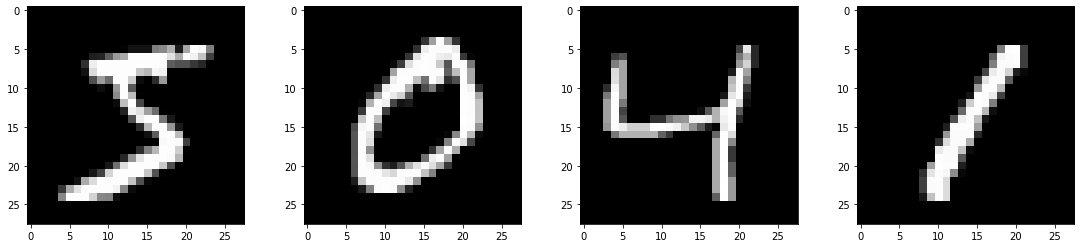

In [5]:
fig, gs = plt.figure(figsize=(19,4)), gridspec.GridSpec(1, 4)

ax = []

for i in range(4):
    ax.append(fig.add_subplot(gs[i]))
    ax[i].imshow(np.array(MNIST_train[i][0][0]), 'gray')
    
plt.show()

Нейросеть принимает на вход вектор, таким образом небходимо "растянуть" матрицу в вектор - первая строка - первые 28 элементов вектора, вторая строка - вторые 28 элеметнов и т.д.

**Полносвязная нейронная сеть (Персептрон)**

![Персептрон](img/perseptron.png 'Персептрон')

Пусть количество нейронов в каждом скрытом слое одинаковое. Пусть функции активации везде одинаковые.

Перепишем в матричном виде:
<center>$
\begin{equation*}
    f(\mathbf{w}, W)=
    W_{n_2+1}\sigma\left(
        \cdots W_2\sigma\left(
            W_1\mathbf{x}
        \right)\cdots
    \right)
\end{equation*}
$,</center>

где
* $n$ - размерность пространства признаков (`input_dim`);
* $n_1$ - размерность скрытого слоя (`hidden_dim`);
* $n_2$ - количество скрытых слоев (`num_layers`);
* $n_3$ - размерность пространтсва ответов (`output_dim`).

Заметим, что при $n_2=0$ получается линейная модель, то есть линейная модель это частный случай полносвязного персептрона.

**Задание нейронной сети в PyTorch**

In [18]:
class Perceptron(torch.nn.Module):
    def __init__(self, input_dim=784, num_layers=0,
                 hidden_dim=64, output_dim=10, p=0.0, device='cpu'):
        # device - устройство, на котором будут производиться вычисления
        
        super(Perceptron, self).__init__()
        
        self.layers = torch.nn.Sequential()
        
        prev_size = input_dim
        for i in range(num_layers):
            # Линейный модуль - добавление одного слоя полносвязной
            # нейронной сети - реадизация скалярного произведения Wx
            self.layers.add_module('layer{}'.format(i+1),
                                   torch.nn.Linear(prev_size, hidden_dim))
            # torch.nn.Linear(prev_size, hidden_dim),
            # prev_size - кол-во нейронов на предыдущем слое (на входе)
            # hidden_dim - кол-во нейронов на следующем слое (на выходе)
            
            # Нелинейный модуль - сигма-функция (в нашем случае ReLU)
            self.layers.add_module('relu{}'.format(i+1), torch.nn.ReLU())
            
            # Удаление нейрона с вероятностью p (Реализация Drop Out):
            self.layers.add_module('dropout{}'.format(i+1), torch.nn.Dropout(p=p))
            
            # Отслеживание согласовонности размерностей выходов и входов
            # смежных слоев:
            prev_size = hidden_dim
            
        # Последний линейный слой
        self.layers.add_module('classifier',
                                torch.nn.Linear(prev_size, output_dim))
        self.to(device)
        
        
    def forward(self, input):
        return self.layers(input)

In [19]:
# Если есть GPU, то подсчеты будт производиться на GPU, в ином слуаче
# расчеты будут производиться на CPU.

# Использование GPU для нейронных сетей является наиболее предпочтительным
# ввиду того, что матричные вычисления на видеокарте работают намного быстрее,
# нежели на процессоре.

# У меня почему-то GPU не доступна.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Что из себя представляет модель Perceptron:

In [20]:
model = Perceptron(device=device)
model

Perceptron(
  (layers): Sequential(
    (classifier): Linear(in_features=784, out_features=10, bias=True)
  )
)

В слоях содержится только один линейный слой

In [21]:
model = Perceptron(num_layers=1, device=device)
model

Perceptron(
  (layers): Sequential(
    (layer1): Linear(in_features=784, out_features=64, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.0, inplace=False)
    (classifier): Linear(in_features=64, out_features=10, bias=True)
  )
)

Слой 1: Линейный слой $\to$ ReLU $\to$ DropOut с вер-стью 0 $\to$ Линейный слой

В линейных слоях есть параметр `bias=True`. Данный параметр отвечает за добавление единицы к признакам объекта. То есть если `bias=True`, то сами признаки подаются на вход сети без преобразования (без добалвения к ним $1$), PyTorch будет делать это самостоятельно внутри сети.

In [22]:
model = Perceptron(num_layers=2, device=device)
model

Perceptron(
  (layers): Sequential(
    (layer1): Linear(in_features=784, out_features=64, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.0, inplace=False)
    (layer2): Linear(in_features=64, out_features=64, bias=True)
    (relu2): ReLU()
    (dropout2): Dropout(p=0.0, inplace=False)
    (classifier): Linear(in_features=64, out_features=10, bias=True)
  )
)

В данном случае скрытых слоев уже два. Также учтена согласованность входов и выходов между смежными слоями:  
Скрытый: `in_features=784, out_features=64`  
Скрытый: `in_features=64, out_features=64`  
Выходной: `in_features=64, out_features=10`

Заметим, что все слои глубокой нейронной сети до выходного представляют собой Feature Engineering. Сам классификатор представляется последним слоем.

In [23]:
def testing(model, dataset):
    generator = torch.utils.data.DataLoader(dataset, batch_size=64)
    # batch_size=64 отвечает за количество объектов, читаемых в одном пакете
    # То есть все объекты (в выборке порядка 60 000 объектов) будут браться
    # поочередно пакетами по 64 объекта, чтобы не перегружать память.
    
    pred = []
    real = []
    for x,y in tqdm(generator, leave=False):
        x = x.view([-1, 784]).to(device)
        y = y.to(device)
        
        pred.extend(torch.argmax(model(x), dim=-1).cpu().numpy().tolist())
        real.extend(y.cpu().numpy().tolist())
        # если подсчет torch.argmax(model(x), dim=-1) производится на GPU,
        # то и все промежуточные результаты будут храниться в видеопамяти.
        # Для сохранения результатов в оперативную память, необходимо
        # перегонять все на процессор применяя .cpu().
        # .numpy().tolist() применяется просто для преобразования в удобный 
        # формат.
        
    return np.mean(np.array(real) == np.array(pred)), \
           classification_report(real, pred)

В данном коде есть минус. Backward работает быстро за счет того, что он помнит все, что считал по дороге. На момент тестирования градиент нам не понадобится, но в данном случае Torch сохранит все промежуточные состояния. Это можно исправить, добавив специальную команду (будет далее).